In [1]:
import tensorflow as tf
from boltzmann.data.mnist import load_mnist
from boltzmann.restricted.base import train
from boltzmann.restricted.bernoulli import (
    BernoulliRBM, HintonInitializer, init_fantasy_latent,
    LogAndPrintInternalInformation)

image_size = (16, 16)
(X, y), _ = load_mnist(image_size=image_size, binarize=True,
                       minval=0, maxval=1)

ambient_size = image_size[0] * image_size[1]
latent_size = 64
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(10).batch(batch_size)
rbm = BernoulliRBM(ambient_size, latent_size, HintonInitializer(X))
fantasy_latent = init_fantasy_latent(rbm, batch_size)
optimizer = tf.optimizers.Adam()
callbacks = [LogAndPrintInternalInformation(rbm, 10)]
fantasy_latent = train(rbm, optimizer, dataset, fantasy_latent,
                       callbacks=callbacks)

step: 0 - mean energy: -1.34137 - recon error: 0.12103 - latent-on ratio: 0.50146 - mean free energy: -21.76162 - kernel: -0.00002 (0.00882) - ambient bias: -5.97312 (6.26845) - latent bias: 0.00003 (0.00098)
step: 10 - mean energy: -1.85918 - recon error: 0.12762 - latent-on ratio: 0.46631 - mean free energy: -20.85503 - kernel: -0.00030 (0.00927) - ambient bias: -5.97349 (6.26824) - latent bias: -0.00005 (0.00412)
step: 20 - mean energy: -2.82167 - recon error: 0.12891 - latent-on ratio: 0.49011 - mean free energy: -18.91721 - kernel: -0.00026 (0.00965) - ambient bias: -5.97332 (6.26843) - latent bias: -0.00020 (0.00581)
step: 30 - mean energy: -4.20553 - recon error: 0.12976 - latent-on ratio: 0.53528 - mean free energy: -19.91127 - kernel: -0.00007 (0.00996) - ambient bias: -5.97295 (6.26877) - latent bias: -0.00040 (0.00700)
step: 40 - mean energy: -4.55325 - recon error: 0.12939 - latent-on ratio: 0.51941 - mean free energy: -22.05259 - kernel: -0.00000 (0.01026) - ambient bias: 

step: 390 - mean energy: -14.97214 - recon error: 0.11908 - latent-on ratio: 0.41309 - mean free energy: -18.66401 - kernel: -0.00444 (0.03543) - ambient bias: -5.97509 (6.26649) - latent bias: 0.00173 (0.02067)
step: 400 - mean energy: -14.92510 - recon error: 0.11462 - latent-on ratio: 0.40186 - mean free energy: -20.02194 - kernel: -0.00470 (0.03701) - ambient bias: -5.97522 (6.26643) - latent bias: 0.00216 (0.02237)
step: 410 - mean energy: -16.06273 - recon error: 0.12268 - latent-on ratio: 0.40674 - mean free energy: -18.00841 - kernel: -0.00495 (0.03858) - ambient bias: -5.97528 (6.26651) - latent bias: 0.00258 (0.02447)
step: 420 - mean energy: -17.00451 - recon error: 0.12616 - latent-on ratio: 0.41492 - mean free energy: -17.89849 - kernel: -0.00507 (0.04023) - ambient bias: -5.97518 (6.26669) - latent bias: 0.00324 (0.02703)
step: 430 - mean energy: -16.66741 - recon error: 0.11484 - latent-on ratio: 0.41504 - mean free energy: -20.94350 - kernel: -0.00532 (0.04189) - ambien

step: 780 - mean energy: -30.09081 - recon error: 0.10406 - latent-on ratio: 0.40259 - mean free energy: -23.35472 - kernel: -0.01137 (0.08879) - ambient bias: -5.97825 (6.26440) - latent bias: 0.02499 (0.07859)
step: 790 - mean energy: -27.90149 - recon error: 0.10068 - latent-on ratio: 0.40845 - mean free energy: -23.81137 - kernel: -0.01197 (0.08964) - ambient bias: -5.97955 (6.26348) - latent bias: 0.02627 (0.08377)
step: 800 - mean energy: -29.11440 - recon error: 0.10101 - latent-on ratio: 0.41016 - mean free energy: -22.19450 - kernel: -0.01241 (0.09054) - ambient bias: -5.98111 (6.26233) - latent bias: 0.02870 (0.09096)
step: 810 - mean energy: -31.36226 - recon error: 0.09656 - latent-on ratio: 0.41943 - mean free energy: -23.46905 - kernel: -0.01232 (0.09189) - ambient bias: -5.98046 (6.26267) - latent bias: 0.02896 (0.08897)
step: 820 - mean energy: -28.42764 - recon error: 0.09531 - latent-on ratio: 0.41296 - mean free energy: -26.31241 - kernel: -0.01214 (0.09350) - ambien

step: 1180 - mean energy: -34.17278 - recon error: 0.08777 - latent-on ratio: 0.38867 - mean free energy: -26.83477 - kernel: -0.02068 (0.12669) - ambient bias: -5.98148 (6.26213) - latent bias: 0.03827 (0.11803)
step: 1190 - mean energy: -34.88577 - recon error: 0.09360 - latent-on ratio: 0.38965 - mean free energy: -24.75353 - kernel: -0.02113 (0.12749) - ambient bias: -5.98196 (6.26198) - latent bias: 0.03872 (0.11881)
step: 1200 - mean energy: -32.36590 - recon error: 0.08618 - latent-on ratio: 0.39136 - mean free energy: -27.03218 - kernel: -0.02214 (0.12766) - ambient bias: -5.98445 (6.26071) - latent bias: 0.04080 (0.12582)
step: 1210 - mean energy: -32.22998 - recon error: 0.08911 - latent-on ratio: 0.38953 - mean free energy: -24.80081 - kernel: -0.02259 (0.12816) - ambient bias: -5.98565 (6.26003) - latent bias: 0.04248 (0.13046)
step: 1220 - mean energy: -32.31034 - recon error: 0.08664 - latent-on ratio: 0.38953 - mean free energy: -26.47624 - kernel: -0.02231 (0.12922) - a

step: 1580 - mean energy: -37.40311 - recon error: 0.08847 - latent-on ratio: 0.37817 - mean free energy: -25.09882 - kernel: -0.02865 (0.15462) - ambient bias: -5.98591 (6.26046) - latent bias: 0.05127 (0.15804)
step: 1590 - mean energy: -37.15613 - recon error: 0.08521 - latent-on ratio: 0.37646 - mean free energy: -26.89221 - kernel: -0.02833 (0.15546) - ambient bias: -5.98450 (6.26121) - latent bias: 0.05010 (0.15500)
step: 1600 - mean energy: -38.07835 - recon error: 0.08408 - latent-on ratio: 0.37805 - mean free energy: -28.12486 - kernel: -0.02805 (0.15642) - ambient bias: -5.98267 (6.26230) - latent bias: 0.04793 (0.14891)
step: 1610 - mean energy: -40.31811 - recon error: 0.09225 - latent-on ratio: 0.37549 - mean free energy: -24.97464 - kernel: -0.02809 (0.15722) - ambient bias: -5.98227 (6.26258) - latent bias: 0.04759 (0.14764)
step: 1620 - mean energy: -37.30235 - recon error: 0.08682 - latent-on ratio: 0.37207 - mean free energy: -25.94290 - kernel: -0.02890 (0.15742) - a

step: 1980 - mean energy: -39.27411 - recon error: 0.07953 - latent-on ratio: 0.38184 - mean free energy: -28.97925 - kernel: -0.03478 (0.17864) - ambient bias: -5.98579 (6.26142) - latent bias: 0.05718 (0.18301)
step: 1990 - mean energy: -41.28067 - recon error: 0.07730 - latent-on ratio: 0.37109 - mean free energy: -28.65619 - kernel: -0.03480 (0.17928) - ambient bias: -5.98532 (6.26166) - latent bias: 0.05717 (0.18254)
step: 2000 - mean energy: -40.32018 - recon error: 0.08313 - latent-on ratio: 0.36646 - mean free energy: -27.44129 - kernel: -0.03478 (0.17996) - ambient bias: -5.98423 (6.26246) - latent bias: 0.05597 (0.17889)
step: 2010 - mean energy: -41.40685 - recon error: 0.07785 - latent-on ratio: 0.37341 - mean free energy: -29.40606 - kernel: -0.03491 (0.18065) - ambient bias: -5.98344 (6.26311) - latent bias: 0.05483 (0.17643)
step: 2020 - mean energy: -42.19345 - recon error: 0.08221 - latent-on ratio: 0.37439 - mean free energy: -28.72395 - kernel: -0.03504 (0.18129) - a

step: 2370 - mean energy: -43.28376 - recon error: 0.07541 - latent-on ratio: 0.36243 - mean free energy: -28.99082 - kernel: -0.04089 (0.20003) - ambient bias: -5.98528 (6.26294) - latent bias: 0.06205 (0.20071)
step: 2380 - mean energy: -41.75155 - recon error: 0.07977 - latent-on ratio: 0.36633 - mean free energy: -29.59513 - kernel: -0.04071 (0.20082) - ambient bias: -5.98409 (6.26373) - latent bias: 0.06092 (0.19807)
step: 2390 - mean energy: -43.94027 - recon error: 0.07602 - latent-on ratio: 0.36914 - mean free energy: -30.29403 - kernel: -0.04095 (0.20125) - ambient bias: -5.98458 (6.26355) - latent bias: 0.06120 (0.20055)
step: 2400 - mean energy: -41.97276 - recon error: 0.07349 - latent-on ratio: 0.37903 - mean free energy: -31.09268 - kernel: -0.04153 (0.20144) - ambient bias: -5.98605 (6.26283) - latent bias: 0.06243 (0.20540)
step: 2410 - mean energy: -41.73962 - recon error: 0.07782 - latent-on ratio: 0.36646 - mean free energy: -29.80458 - kernel: -0.04188 (0.20177) - a

step: 2760 - mean energy: -42.78735 - recon error: 0.07782 - latent-on ratio: 0.34998 - mean free energy: -26.66002 - kernel: -0.04692 (0.21941) - ambient bias: -5.98667 (6.26253) - latent bias: 0.06835 (0.22741)
step: 2770 - mean energy: -44.16172 - recon error: 0.07150 - latent-on ratio: 0.35583 - mean free energy: -30.78819 - kernel: -0.04678 (0.22013) - ambient bias: -5.98540 (6.26338) - latent bias: 0.06725 (0.22387)
step: 2780 - mean energy: -42.39589 - recon error: 0.06927 - latent-on ratio: 0.36804 - mean free energy: -32.79495 - kernel: -0.04690 (0.22071) - ambient bias: -5.98511 (6.26365) - latent bias: 0.06721 (0.22231)
step: 2790 - mean energy: -45.14793 - recon error: 0.07556 - latent-on ratio: 0.35645 - mean free energy: -28.48726 - kernel: -0.04731 (0.22106) - ambient bias: -5.98604 (6.26312) - latent bias: 0.06810 (0.22554)
step: 2800 - mean energy: -40.51096 - recon error: 0.07687 - latent-on ratio: 0.35632 - mean free energy: -28.95599 - kernel: -0.04782 (0.22132) - a

step: 3150 - mean energy: -42.05535 - recon error: 0.07425 - latent-on ratio: 0.35376 - mean free energy: -29.41893 - kernel: -0.05218 (0.23753) - ambient bias: -5.98753 (6.26283) - latent bias: 0.07394 (0.25784)
step: 3160 - mean energy: -42.91732 - recon error: 0.06757 - latent-on ratio: 0.35205 - mean free energy: -31.26170 - kernel: -0.05208 (0.23807) - ambient bias: -5.98708 (6.26286) - latent bias: 0.07428 (0.25790)
step: 3170 - mean energy: -42.70405 - recon error: 0.07080 - latent-on ratio: 0.35596 - mean free energy: -30.66326 - kernel: -0.05191 (0.23870) - ambient bias: -5.98561 (6.26368) - latent bias: 0.07283 (0.25315)
step: 3180 - mean energy: -46.31680 - recon error: 0.07590 - latent-on ratio: 0.34717 - mean free energy: -29.05038 - kernel: -0.05176 (0.23936) - ambient bias: -5.98411 (6.26471) - latent bias: 0.07129 (0.24783)
step: 3190 - mean energy: -45.41365 - recon error: 0.07541 - latent-on ratio: 0.35205 - mean free energy: -29.93615 - kernel: -0.05206 (0.23981) - a

step: 3540 - mean energy: -47.97377 - recon error: 0.07144 - latent-on ratio: 0.35010 - mean free energy: -31.25226 - kernel: -0.05680 (0.25503) - ambient bias: -5.98482 (6.26562) - latent bias: 0.07644 (0.27558)
step: 3550 - mean energy: -47.28828 - recon error: 0.07144 - latent-on ratio: 0.34485 - mean free energy: -31.27482 - kernel: -0.05674 (0.25556) - ambient bias: -5.98466 (6.26553) - latent bias: 0.07691 (0.27756)
step: 3560 - mean energy: -45.95736 - recon error: 0.07376 - latent-on ratio: 0.34338 - mean free energy: -29.50833 - kernel: -0.05673 (0.25604) - ambient bias: -5.98464 (6.26543) - latent bias: 0.07757 (0.27899)
step: 3570 - mean energy: -46.07732 - recon error: 0.07053 - latent-on ratio: 0.35327 - mean free energy: -31.62893 - kernel: -0.05681 (0.25644) - ambient bias: -5.98458 (6.26556) - latent bias: 0.07771 (0.27826)
step: 3580 - mean energy: -47.78798 - recon error: 0.07477 - latent-on ratio: 0.34473 - mean free energy: -29.44854 - kernel: -0.05702 (0.25680) - a

step: 3930 - mean energy: -49.64299 - recon error: 0.07245 - latent-on ratio: 0.34180 - mean free energy: -30.83222 - kernel: -0.06124 (0.27175) - ambient bias: -5.98224 (6.26763) - latent bias: 0.07853 (0.29515)
step: 3940 - mean energy: -49.88926 - recon error: 0.07281 - latent-on ratio: 0.34338 - mean free energy: -30.39557 - kernel: -0.06166 (0.27216) - ambient bias: -5.98274 (6.26719) - latent bias: 0.07843 (0.29661)
step: 3950 - mean energy: -46.16665 - recon error: 0.06827 - latent-on ratio: 0.35107 - mean free energy: -31.12018 - kernel: -0.06237 (0.27232) - ambient bias: -5.98447 (6.26610) - latent bias: 0.07978 (0.30134)
step: 3960 - mean energy: -46.88219 - recon error: 0.06570 - latent-on ratio: 0.34802 - mean free energy: -32.26958 - kernel: -0.06284 (0.27249) - ambient bias: -5.98588 (6.26527) - latent bias: 0.08157 (0.30558)
step: 3970 - mean energy: -45.79134 - recon error: 0.07129 - latent-on ratio: 0.33911 - mean free energy: -30.40884 - kernel: -0.06295 (0.27285) - a

step: 4320 - mean energy: -53.08826 - recon error: 0.07007 - latent-on ratio: 0.34265 - mean free energy: -32.71820 - kernel: -0.06506 (0.28729) - ambient bias: -5.98060 (6.26938) - latent bias: 0.08473 (0.31952)
step: 4330 - mean energy: -47.31192 - recon error: 0.07019 - latent-on ratio: 0.34167 - mean free energy: -32.36282 - kernel: -0.06531 (0.28767) - ambient bias: -5.98086 (6.26922) - latent bias: 0.08474 (0.32196)
step: 4340 - mean energy: -47.98822 - recon error: 0.06363 - latent-on ratio: 0.34204 - mean free energy: -33.96609 - kernel: -0.06602 (0.28777) - ambient bias: -5.98247 (6.26835) - latent bias: 0.08547 (0.32827)
step: 4350 - mean energy: -48.98337 - recon error: 0.06519 - latent-on ratio: 0.34509 - mean free energy: -33.30845 - kernel: -0.06660 (0.28789) - ambient bias: -5.98383 (6.26768) - latent bias: 0.08653 (0.33381)
step: 4360 - mean energy: -46.47938 - recon error: 0.06381 - latent-on ratio: 0.36023 - mean free energy: -35.31937 - kernel: -0.06671 (0.28827) - a

In [2]:
from sklearn.manifold import TSNE
from boltzmann.restricted.base import relax, RestrictedBoltzmannMachine

def get_relaxed_latent_projection(
        rbm: RestrictedBoltzmannMachine,
        ambient: tf.Tensor,
        max_iter: int = 10,
        tol: float = 1e-8):
    relaxed_ambient, _ = relax(rbm, ambient, max_iter, tol)
    relaxed_latent = rbm.get_latent_given_ambient(relaxed_ambient).prob_argmax
    projection = TSNE().fit_transform(relaxed_latent)
    return projection

In [3]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(rbm, np.array(X_in_labels))

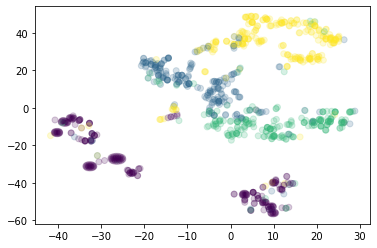

In [4]:
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()